# CS236 Project 

## Contributions

#### Justin Yee (jyee048)
    - 1.2 Exploratory Data Analysis

#### Nicko Martinez (nmart130)
    - 1.3 Data Processing


## Set up

Experience working with large dataset, has made my partner and I aware of how quickly files can get misplaced, so we stressed keeping the file system and repository organized.

- Path `data/clean` holds all data files that are requested from Project description.

- Path `data/raw` holds the original data with no modifications made.

### Project Structure

```
.
├── .venv/
│
├── data/
│   ├── clean/
│   │   ├── customer_df.csv
│   │   ├── hotel_df.csv
│   │   └── merged_df.csv
│   │
│   └── raw/
│       ├── customer-reservations.csv
│       └── hotel-booking.csv
│
├── .gitignore
├── Course_Project.pdf
├── merged_df.csv
├── Phase01.ipynb
└── requirements.txt

```


## Installation Process

- set up of pyspark was done using a (.venv)
- The choice to use a virtual environment was to ensure both my partner and I were using compatible versions of packages, which could be validated from the `requirements.txt` file. `pip freeze > requirements.txt`

Using the following commands we set up our working environmnet

```
python -m venv .venv
source .venv/bin/activate
pip install [PACKAGES]
```

The current python interpreter being used was 3.13 and pyspark(3.5.1) command was failing to run. So installed python3.11 instead and ran into the same problem. (Turns out version compatability wasn't the problem)

command `pyspark <filename.py` in the instructions. For whatever reason was not being linked properly or just not executing as it should. instead `python <filenmae.py` seemed to run and execute perfectly. 

Docker was already installed on machine.


## 1.2 Exploratory Data Analysis (EDA)

This section performs comprehensive exploratory data analysis on both hotel booking datasets to understand their structure, quality, and characteristics before merging.

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import os

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Hotel Bookings EDA") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.host", "localhost") \
    .config("spark.ui.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("\nLoading datasets...")

df1 = spark.read.csv("C:/Users/justi/OneDrive/CS 236/FinalProject236/data/raw/hotel-booking.csv", header=True, inferSchema=True)
df2 = spark.read.csv("C:/Users/justi/OneDrive/CS 236/FinalProject236/data/raw/customer-reservations.csv", header=True, inferSchema=True)

print(f"Hotel Booking dataset loaded: {df1.count()} rows")
print(f"Customer Reservations dataset loaded: {df2.count()} rows")


Loading datasets...
Hotel Booking dataset loaded: 78703 rows
Customer Reservations dataset loaded: 36275 rows


In [6]:
print(f"Hotel Booking loaded: {df1.count()} rows")
print(f"Customer Reservations loaded: {df2.count()} rows")
print("\n--- Hotel Booking Schema ---")
df1.printSchema()
print("\n--- Customer Reservations Schema ---")
df2.printSchema()
# Compare column names
cols1 = set(df1.columns)
cols2 = set(df2.columns)

print("\n--- Column Comparison ---")
print(f"Hotel Booking has {len(cols1)} columns")
print(f"Customer Reservations has {len(cols2)} columns")
print(f"Overlapping columns: {len(cols1.intersection(cols2))}")
# FIND UNIQUE COLUMNS
unique_to_1 = cols1 - cols2
unique_to_2 = cols2 - cols1

if unique_to_1:
    print(f"\nUnique to Hotel Booking ({len(unique_to_1)} columns):")
    for column in sorted(unique_to_1):
        print(f"  - {column}")

if unique_to_2:
    print(f"\nUnique to Customer Reservations ({len(unique_to_2)} columns):")
    for column in sorted(unique_to_2):
        print(f"  - {column}")

Hotel Booking loaded: 78703 rows
Customer Reservations loaded: 36275 rows

--- Hotel Booking Schema ---
root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- country: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- email: string (nullable = true)


--- Customer Reservations Schema ---
root
 |-- Booking_ID: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable 

### Dataset Overview

The analysis examines two datasets:
- **Hotel Booking**: 78,703 rows with 13 columns
- **Customer Reservations**: 36,275 rows with 10 columns

Both datasets share 8 common columns related to booking information, while each contains unique fields specific to their data collection methods.

### Schema Analysis

**Hotel Booking Dataset** contains:
- Guest information (email, country)
- Hotel type classification
- Temporal data (arrival year, month, week number, day of month)
- Booking characteristics (lead time, weekend/weeknight stays)
- Business metrics (market segment, average price, booking status)

**Customer Reservations Dataset** contains:
- Unique booking identifier (Booking_ID)
- Temporal data (arrival year, month, date)
- Booking characteristics (lead time, weekend/weeknight stays)
- Business metrics (market segment, average price, booking status)

**Key Differences**:
- Hotel Booking includes geographic data (country) and contact information (email)
- Customer Reservations uses a unique Booking_ID for record identification
- Date representations differ: Hotel Booking uses week numbers and day of month, while Customer Reservations uses arrival_date

In [7]:
# NULL VALUE ANALYSIS
print("\nNull Value Analysis...")

def analyze_nulls(df, name):
    """Analyze null values in the dataset"""
    print(f"\n--- {name} Null Analysis ---")
    
    # Calculate null counts for all columns
    null_counts = []
    for c in df.columns:
        null_count = df.filter(col(c).isNull()).count()
        null_counts.append((c, null_count))
    
    # Filter and sort columns with nulls
    columns_with_nulls = [(c, n) for c, n in null_counts if n > 0]
    columns_with_nulls.sort(key=lambda x: x[1], reverse=True)
    
    total_rows = df.count()
    
    if columns_with_nulls:
        print(f"Columns with null values: {len(columns_with_nulls)}/{len(df.columns)}")
        print(f"\n{'Column':<30} {'Null Count':>12} {'Percentage':>12}")
        print("-" * 56)
        for col_name, null_count in columns_with_nulls:
            pct = (null_count / total_rows) * 100
            print(f"{col_name:<30} {null_count:>12,} {pct:>11.2f}%")
    else:
        print("No null values found!")

analyze_nulls(df1, "Hotel Booking")
analyze_nulls(df2, "Customer Reservations")


Null Value Analysis...

--- Hotel Booking Null Analysis ---
Columns with null values: 1/13

Column                           Null Count   Percentage
--------------------------------------------------------
country                                 405        0.51%

--- Customer Reservations Null Analysis ---
No null values found!


#### Null Values
- **Hotel Booking**: Only 405 null values (0.51%) in the country column, indicating high data completeness
- **Customer Reservations**: No null values detected across all columns, representing perfect data completeness

The minimal missing data suggests both datasets are well maintained and suitable for analysis without extensive imputation.


Distinct Value Analysis...

--- Hotel Booking Distinct Values ---

Column                            Distinct Values    Uniqueness %
-----------------------------------------------------------------
hotel                                           2           0.00%
booking_status                                  2           0.00%
lead_time                                     439           0.56%
arrival_year                                    2           0.00%
arrival_month                                  12           0.02%
arrival_date_week_number                       53           0.07%
arrival_date_day_of_month                      31           0.04%
stays_in_weekend_nights                        17           0.02%
stays_in_week_nights                           32           0.04%
market_segment_type                             8           0.01%
country                                       160           0.20%
avg_price_per_room                          6,985           8.88%
email   

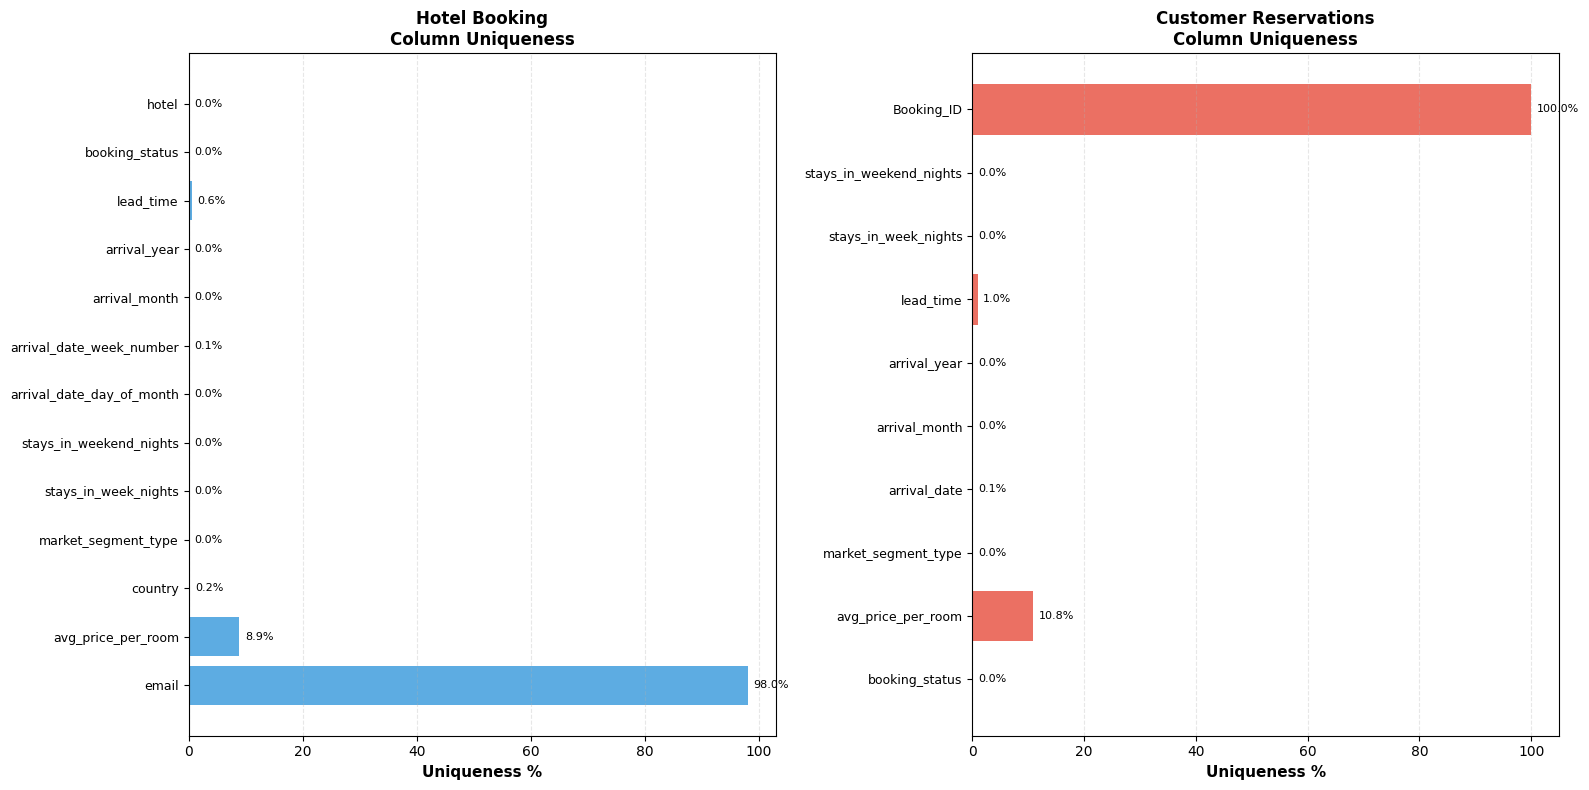

In [8]:
# DISTINCT VALUE ANALYSIS
print("\nDistinct Value Analysis...")

def analyze_distinct_values(df, name):
    """Analyze distinct values for all columns"""
    print(f"\n--- {name} Distinct Values ---")
    print(f"\n{'Column':<30} {'Distinct Values':>18} {'Uniqueness %':>15}")
    print("-" * 65)
    
    total_rows = df.count()
    
    # Store data for plotting
    plot_data = []
    
    for c in df.columns:
        distinct_count = df.select(c).distinct().count()
        uniqueness = (distinct_count / total_rows) * 100
        print(f"{c:<30} {distinct_count:>18,} {uniqueness:>14.2f}%")
        plot_data.append((c, uniqueness))
    
    return plot_data

# Run analysis and store results
data1 = analyze_distinct_values(df1, "Hotel Booking")
data2 = analyze_distinct_values(df2, "Customer Reservations")

# Create visualization
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Hotel Booking
cols1, uniq1 = zip(*data1)
y_pos1 = np.arange(len(cols1))
bars1 = ax1.barh(y_pos1, uniq1, alpha=0.8, color='#3498db')
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(cols1, fontsize=9)
ax1.set_xlabel('Uniqueness %', fontsize=11, fontweight='bold')
ax1.set_title('Hotel Booking\nColumn Uniqueness', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars1, uniq1)):
    ax1.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8)

# Plot for Customer Reservations
cols2, uniq2 = zip(*data2)
y_pos2 = np.arange(len(cols2))
bars2 = ax2.barh(y_pos2, uniq2, alpha=0.8, color='#e74c3c')
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(cols2, fontsize=9)
ax2.set_xlabel('Uniqueness %', fontsize=11, fontweight='bold')
ax2.set_title('Customer Reservations\nColumn Uniqueness', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars2, uniq2)):
    ax2.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

#### Distinct Values Analysis

**High Cardinality Columns**:
- email (Hotel Booking): 77,144 unique values (98.02% unique) - nearly one per record
- Booking_ID (Customer Reservations): 36,275 unique values (100% unique) - perfect identifier

**Medium Cardinality Columns**:
- avg_price_per_room: 6,985 unique values in Hotel Booking, 3,930 in Customer Reservations
- lead_time: 439 unique values in Hotel Booking, 352 in Customer Reservations
- country (Hotel Booking): 160 unique countries

**Low Cardinality Columns** :
- hotel: 2 types
- booking_status: 2 statuses
- arrival_year: 2 years
- arrival_month: 12 months
- market_segment_type: 8 types in Hotel Booking, 5 in Customer Reservations
- stays_in_weekend_nights: 17 unique values in Hotel Booking, 8 in Customer Reservations
- stays_in_week_nights: 32 unique values in Hotel Booking, 18 in Customer Reservations


Data Type Analysis...

--- Hotel Bookings Data Types ---

Data Type                 Count
--------------------------------
int                           7
string                        5
double                        1

--- Customer Reservations Data Types ---

Data Type                 Count
--------------------------------
int                           6
string                        3
double                        1


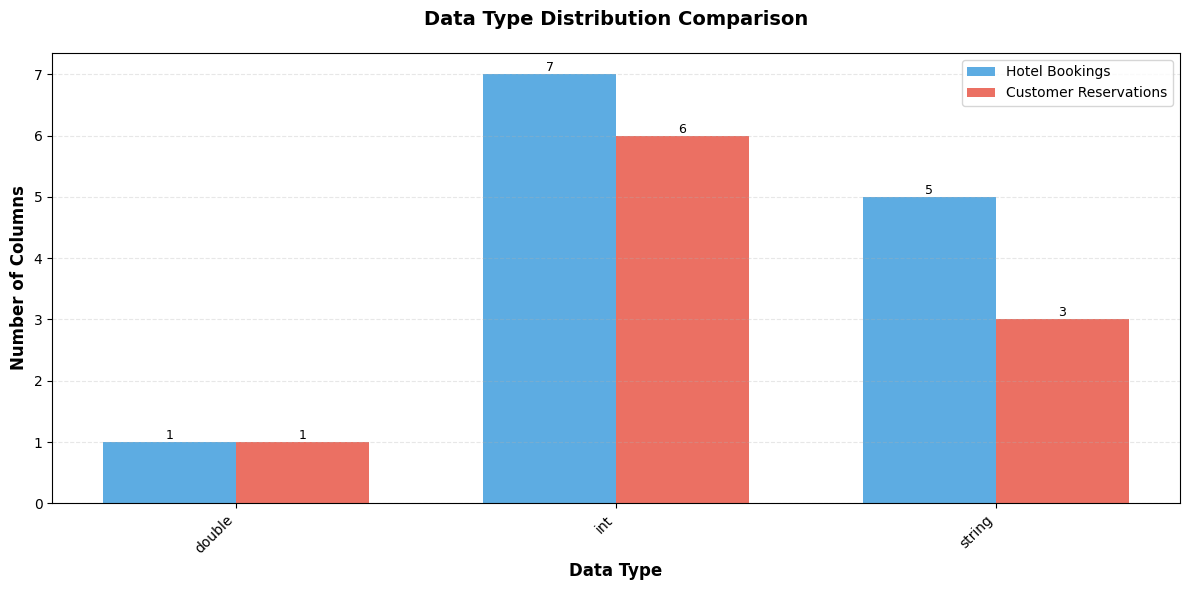

In [9]:
# DATA TYPE ANALYSIS
print("\nData Type Analysis...")

def analyze_data_types(df, name):
    """Show data types distribution"""
    print(f"\n--- {name} Data Types ---")
    
    type_counts = {}
    for col_name, col_type in df.dtypes:
        type_counts[col_type] = type_counts.get(col_type, 0) + 1
    
    print(f"\n{'Data Type':<20} {'Count':>10}")
    print("-" * 32)
    for dtype, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{dtype:<20} {count:>10}")

analyze_data_types(df1, "Hotel Bookings")
analyze_data_types(df2, "Customer Reservations")

# Create visualization
import matplotlib.pyplot as plt
import numpy as np

def plot_data_types(df1, df2, name1="Hotel Bookings", name2="Customer Reservations"):
    def get_type_counts(df):
        type_counts = {}
        for col_name, col_type in df.dtypes:
            type_counts[col_type] = type_counts.get(col_type, 0) + 1
        return type_counts
    
    types1 = get_type_counts(df1)
    types2 = get_type_counts(df2)
    
    all_types = sorted(set(list(types1.keys()) + list(types2.keys())))
    
    counts1 = [types1.get(dtype, 0) for dtype in all_types]
    counts2 = [types2.get(dtype, 0) for dtype in all_types]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(all_types))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, counts1, width, label=name1, alpha=0.8, color='#3498db')
    bars2 = ax.bar(x + width/2, counts2, width, label=name2, alpha=0.8, color='#e74c3c')
    
    ax.set_xlabel('Data Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Columns', fontsize=12, fontweight='bold')
    ax.set_title('Data Type Distribution Comparison', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(all_types, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9)
    
    add_labels(bars1)
    add_labels(bars2)
    
    plt.tight_layout()
    plt.show()

plot_data_types(df1, df2)

In [10]:
# DATA TYPE MISMATCHES
print("\nChecking for Data Type Mismatches...")

def compare_column_types(df1, df2):
    """Compare data types of common columns"""
    common_cols = sorted(set(df1.columns).intersection(set(df2.columns)))
        
    df1_types = dict(df1.dtypes)
    df2_types = dict(df2.dtypes)
    
    mismatches = []
    matches = []
    
    for col_name in common_cols:
        type1 = df1_types[col_name]
        type2 = df2_types[col_name]
        
        if type1 != type2:
            mismatches.append((col_name, type1, type2))
        else:
            matches.append(col_name)
    return mismatches

common_cols = sorted(set(df1.columns).intersection(set(df2.columns)))

print(f"\nComparing {len(common_cols)} common columns...")
type_mismatches = compare_column_types(df1, df2)

if type_mismatches:
    print(f"\nFound {len(type_mismatches)} type mismatches:")
    print(f"\n{'Column':<30} {'Hotel Bookings Type':<20} {'Customer Reservations Type':<20}")
    print("-" * 72)
    
    for col_name, type1, type2 in type_mismatches:
        print(f"{col_name:<30} {type1:<20} {type2:<20}")
else:
    print("\nAll common columns have matching types!")


Checking for Data Type Mismatches...

Comparing 8 common columns...

Found 2 type mismatches:

Column                         Hotel Bookings Type  Customer Reservations Type
------------------------------------------------------------------------
arrival_month                  string               int                 
booking_status                 int                  string              


#### Data Type Mismatches

Two critical mismatches were identified in common columns:

1. **arrival_month**:
   - Hotel Booking: string (month names like "January", "February")
   - Customer Reservations: int (numeric month 1-12)

2. **booking_status**:
   - Hotel Booking: int (0/1 encoding)
   - Customer Reservations: string ("Canceled"/"Not_Canceled")

### Key Findings

1. **Data Completeness**: Both datasets have good data quality with minimal missing values
2. **Overlap**: Substantial column overlap (8/13 and 8/10) enables meaningful data integration
3. **Type Inconsistencies**: Identified mismatches require preprocessing before merge operations
4. **Granularity**: Email field's high uniqueness suggests guest level granularity in Hotel Booking
5. **Identifier Strength**: Booking_ID provides perfect unique identification in Customer Reservations
6. **Geographic Coverage**: 160 countries represented indicates global hotel operations
7. **Temporal Span**: Both datasets cover 2 years of booking activity, but different time periods

## 1.3 Data Processing

During class TA stated that `pyspark` was just a recommendation. Because of that and me being more familiar with pandas, I chose to work with pandas instead.

## Resolving Datatype Mismatches for overlapping columns

- Solution: 
  - Map datatype(s): `string` to `integers`
  - hotel dataFrame `arrival_month`: \{ "January":1, "February": 2, ... , "December": 12 \}
  - Customer dataframe `booking_status`: \{ "Canceled": 1, "Not_Canceled": 0\}
    - To make this column more interpretable we renamed 'booking_status' to 'is_canceled'
    - NOTE: There is nothing that necessarily states (1) or (0) represents "Canceled" bookings, but we assume the standardization of 0: False (booking has not been canceled and 1: True (booking has been cancelled). 
- Reason: 
  - Prefer to deal with numerical representation rather than string data.
  - Strings are more difficult to work with considering that strings hold meaning that must first be translated and defined in software.

In [ ]:
import pandas as pd

DATA_PATH = "data/"
RAW_DATA_PATH = f"{DATA_PATH}/raw"

# Map arrival months to numerical representations.
arrival_month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

# Loading in .csv file from
hotel_df = pd.read_csv(f"{RAW_DATA_PATH}/hotel-booking.csv")

# renaming `booking_status` to `is_canceled` in hotel_df then mapping them to booleans. Then removing `booking_status` column 
hotel_df['is_canceled'] = hotel_df['booking_status'].copy()
hotel_df['arrival_month'] = hotel_df['arrival_month'].map(arrival_month_map)

# renaming 'arrival_date_day_of_month' column to match with customers dataframe
hotel_df['arrival_day'] = hotel_df['arrival_date_day_of_month'].copy()

hotel_df.drop('arrival_date_day_of_month', axis=1, inplace=True)
hotel_df.drop('booking_status', axis=1, inplace=True)

# created one column to represent the date by merging date columns.
hotel_df["arrival_date"] = pd.to_datetime(
    hotel_df["arrival_year"].astype(str) + "-" +
    hotel_df["arrival_month"].astype(str) + "-" +
    hotel_df["arrival_day"].astype(str),
    format="%Y-%m-%d"
)
hotel_df.to_csv(f"{DATA_PATH}/clean/hotel_df.csv")

`customer_df['arrival_date']` seems to be a poor column name considering it is only the day of the month. Will be renaming column to 'arriva_day' as well as creating a new column to represent the acutal 'arrival_date' with the "Year-Month-day" format.

In [ ]:

# renaming 'booking_status' to `is_canceled in customer_df then mapping them to booleans. Then removing booking_status column.
customer_df = pd.read_csv(f"{DATA_PATH}/raw/customer-reservations.csv")

# map for booking_status to boolean numerical values.
booking_status_map = {"Not_Canceled": 0, "Canceled": 1}

# mapping `booking status` to boolean vals, storing them in 'is_canceled' column  
customer_df['is_canceled'] = customer_df['booking_status'].map(booking_status_map)
# removing `booking_status` column, ensuring that data is dropped inplace
customer_df.drop('booking_status', axis=1, inplace=True)
# essentially just renaming 'arrival_date' column to arrival_day
customer_df['arrival_day'] = customer_df['arrival_date'].copy()

# updating the arrival_date column with an actual 'date'.
customer_df["arrival_date"] = pd.to_datetime(
    customer_df["arrival_year"].astype(str) + "-" +
    customer_df["arrival_month"].astype(str) + "-" +
    customer_df["arrival_day"].astype(str),
    format="%Y-%m-%d",
    errors="coerce"
)

customer_df.to_csv(f"{DATA_PATH}/clean/customer_df.csv")

In [7]:
merged_df = pd.concat([hotel_df, customer_df], axis=0, ignore_index=True, sort=False)
merged_df.to_csv(f"{DATA_PATH}/clean/merged_df.csv")

In [8]:
merged_df

,hotel,lead_time,arrival_year,arrival_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,market_segment_type,country,avg_price_per_room,email,is_canceled,arrival_day,arrival_date,Booking_ID
0,Resort Hotel,342,2015,7,27.0,0,0,Direct,PRT,0.00,Ernest.Barnes31@outlook.com,0,1,2015-07-01,NaN
1,Resort Hotel,737,2015,7,27.0,0,0,Direct,PRT,0.00,Andrea_Baker94@aol.com,0,1,2015-07-01,NaN
2,Resort Hotel,7,2015,7,27.0,0,1,Direct,GBR,75.00,Rebecca_Parker@comcast.net,0,1,2015-07-01,NaN
3,Resort Hotel,13,2015,7,27.0,0,1,Corporate,GBR,75.00,Laura_M@gmail.com,0,1,2015-07-01,NaN
4,Resort Hotel,14,2015,7,27.0,0,2,Online TA,GBR,98.00,LHines@verizon.com,0,1,2015-07-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114973,NaN,85,2018,8,NaN,2,6,Online,NaN,167.80,NaN,0,3,2018-08-03,INN36271
114974,NaN,228,2018,10,NaN,1,3,Online,NaN,90.95,NaN,1,17,2018-10-17,INN36272
114975,NaN,148,2018,7,NaN,2,6,Online,NaN,98.39,NaN,0,1,2018-07-01,INN36273
114976,NaN,63,2018,4,NaN,0,3,Online,NaN,94.50,NaN,1,21,2018-04-21,INN36274
